In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [31]:
len(words)

32033

In [32]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [66]:
# build the dataset

block_size = 3
X, Y = [], []
for w in words:
    
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [152]:
# build the dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [67]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [35]:
C = torch.randn((27,2))

In [36]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [37]:
emb.view(32,6).shape

torch.Size([32, 6])

In [38]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [39]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [40]:
h

tensor([[-0.9756,  0.8317,  0.9890,  ...,  0.9959,  0.0921,  0.9552],
        [-0.9989,  0.7954,  0.9997,  ...,  1.0000, -0.9536,  0.9693],
        [-0.9999,  0.8037,  0.9499,  ...,  1.0000, -0.7377,  0.7995],
        ...,
        [ 0.4344,  0.9949,  0.9897,  ...,  0.9300, -1.0000, -0.8575],
        [ 0.9999,  0.9233,  0.9893,  ..., -1.0000, -1.0000,  0.6704],
        [ 0.4732,  0.9276,  0.9878,  ...,  1.0000,  0.2305,  0.4250]])

In [41]:
h.shape

torch.Size([32, 100])

In [42]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [43]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [44]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([32, 27])

In [45]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(15.9074)

# ------- Rewrite of above code (clearer) -------

In [212]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [213]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [214]:
sum(p.nelement() for p in parameters) # number of parameters

11897

In [215]:
for p in parameters:
    p.requires_grad = True

In [216]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [217]:
lri = []
lossi = []
stepi = []

In [218]:
for i in range(200000):
    
    # minibatches
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

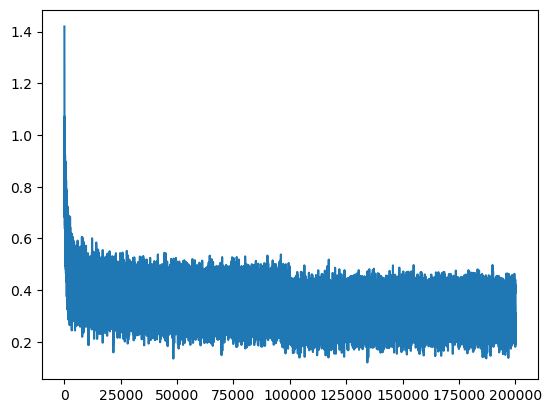

In [219]:
plt.plot(stepi, lossi)

In [220]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1224, grad_fn=<NllLossBackward0>)

In [221]:
emb = C[Xva] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yva)
loss

tensor(2.1590, grad_fn=<NllLossBackward0>)

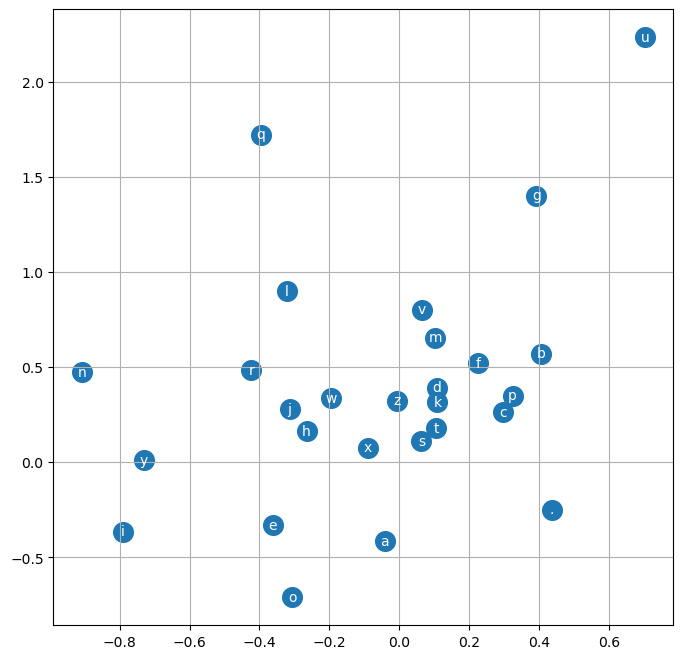

In [195]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color = 'white')
plt.grid('minor')

In [225]:
# sample from the model

g = torch.Generator().manual_seed(2147483650)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

haidenny.
aline.
don.
kamargan.
cambrino.
zhenn.
ansh.
ancero.
aveel.
dangeresleynn.
kivia.
meera.
remalinae.
mon.
yte.
jene.
evekeliili.
jerizon.
kyxley.
jinn.
